<a href="https://colab.research.google.com/github/HughYau/Research-with-Python/blob/main/NonstochasticCakeProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

考虑这样一个简单的吃蛋糕的问题：（此模型其实可以看作是RCK最优增长模型的家庭效用最大化的决策问题）
你有一个蛋糕大小是$W_{1}$,每期消费量$c_{t}$,当期蛋糕剩余量为$W_{t}$,蛋糕效用的“折现率”为$\beta$,蛋糕每期的持有回报率为$\rho$,现在考虑吃蛋糕的人的效用最大化问题，为使问题更加具体化，不妨设效用函数$\mu(c)=\frac{c^{1-\gamma}}{1-\gamma}$（CRRA效用函数）,考虑如下一个最优化问题：
$$
 \max_{\{c_{t}\}_{1}^{\infty},\{W_{t}\}_{2}^{\infty}}\sum_{t=1}^{\infty}\beta^{t}\mu(c_{t})\\
 s.t.W_{t+1}=\rho (W_{t}-c_{t})
$$
求其贝尔曼方程为：$V(W_{t})=\mu(c_{t})+\beta V(W_{t+1})$,过程如下：
定义其值函数$V（W_{t}）=max\{\sum_{a=t}^{\infty}\beta^{a-t}\mu(c_{a})\}$：
 $$
  \begin{aligned}
 V(W_{1})&=max\{\mu(c_{1})+\beta\mu(c_{2})+...+\beta^{t-1}\mu(c_{t})+...\}\\
&=\mu(c_{1})+\beta max\{\mu(c_{2})+...+\beta^{t-2}\mu(c_{t})+...\}\\
&=\mu(c_{1})+\beta V(W_{2})\\
由递归同理可得：\\
 V(W_{t})&=\mu(c_{t})+\beta V(W_{t+1})\\
 &=\mu(\rho (W_{t}-W_{t+1}))+\beta V(W_{t+1})
 \end{aligned}
$$

则原问题转换为对贝尔曼方程的动态规划(本题特指无限期确定性动态规划)问题：
$$
V(W_{t})=max\{\mu(c_{t})+\beta V(\rho (W_{t}-c_{t}))\}
$$
程序主要通过迭代法求近似解（数理方法亦可解出准确解：值函数：$V^*(W_t) = \left( 1-\beta^{1/\gamma} \right)^{-\gamma}u(W_t)$,策略函数:$c^*_{t}(W_{t}) = \left( 1-\beta^{1/\gamma} \right) W_{t}$）

In [ ]:
%matplotlib inline 
from __future__ import division 
from scipy.interpolate import InterpolatedUnivariateSpline #一维插值函数
from scipy.optimize import fminbound #求其最小值的函数，返回其最小值点
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt #绘图
import numpy as np

In [ ]:
class CakeProblem(object):
        def __init__(self, beta=0.96, r = 1.0, gamma = 1.5, 
            grid_max=2.5, grid_min = 1e-3, grid_size=120):#grid_max代表蛋糕的尺寸,size代表点集的数量

            self.r, self.beta, self.gamma = r, beta, gamma #变量初始化，具体说明见题意
            if  gamma != 1.0:
                self.u = lambda c: (c**(1 - gamma))/(1 - gamma)
            else:
                self.u = np.log
                self.gamma = 1
            self.grid = np.linspace(grid_min, grid_max, grid_size)#生成插值点
            
        def bellman_operator(self, w):#定义贝尔曼方程，用于后面的迭代求解
            Vx = InterpolatedUnivariateSpline(self.grid, w)#对W进行关于grid的一维插值

            Tw = np.empty(len(w))
            c = np.empty(len(w))
            for i, x in enumerate(self.grid):
                value = lambda c: - self.u(c) - self.beta * Vx(self.r*(x - c))#定义贝尔曼方程
                c_star = fminbound(value, 1e-6, x-1e-6)#最优化
                Tw[i] = - value(c_star)
                c[i] = c_star

            return Tw,c #返回值包含两个，一个是迭代得到的的值的集合，一个是对应的最优c的值

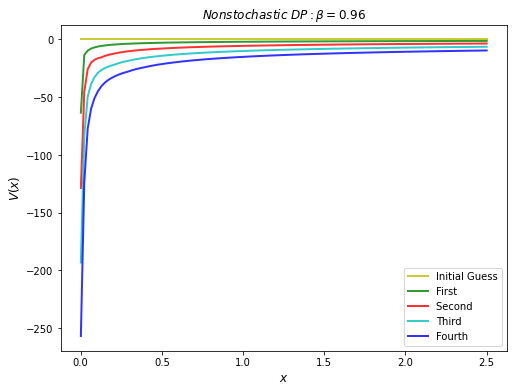

In [ ]:
cp = CakeProblem()
v_zero = np.zeros(len(cp.grid)) #初始化v的值
v_one = cp.bellman_operator(v_zero)[0] #第一次迭代
v_two = cp.bellman_operator(v_one)[0] #第二次迭代
v_three = cp.bellman_operator(v_two)[0]#第三次迭代
v_four = cp.bellman_operator(v_three)[0]#第四次迭代


fig, ax = plt.subplots(figsize =(8,6))

ax.plot(cp.grid, v_zero, 'y-', lw = 2, alpha = .8, label='Initial Guess')
ax.plot(cp.grid, v_one, 'g-', lw = 2, alpha = .8, label='First ')
ax.plot(cp.grid, v_two, 'r-', lw = 2, alpha = .8, label='Second ')
ax.plot(cp.grid, v_three, 'c-', lw = 2, alpha = .8, label='Third ')
ax.plot(cp.grid, v_four, 'b-', lw = 2, alpha = .8, label='Fourth ')
ax.legend()#loc = 'lower right', fontsize='x-large')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)

t = r'$Nonstochastic \ DP:\beta = {0:.2f}$'.format(cp.beta)
ax.set_title(t)

plt.show()

In [ ]:
def compute_fixed_point(T, v, error_tol=1e-3, max_iter=500,#进行迭代的函数，T代表传入的值函数（贝尔曼方程），v代表上次迭代的值，error_tol代表误差范围，max_iter代表最大迭代次数，            
                            print_skip=25,verbose=True):#print_skip代表打印结果的间隔，verbose代表是否打印结果
        i = 0
        error = error_tol + 1

        while i < max_iter and error > error_tol:
            new_v = T(v)[0]
            i += 1
            error = np.max(np.abs(new_v - v))
            if verbose and i % print_skip == 0:
                print(f"第 {i}步收敛结果是  {error}.")
                
            v = new_v
        if i == max_iter:
            print("收敛失败")
        if verbose and i < max_iter:
            print(f"\n在第 {i} 步收敛")


        return v

In [ ]:
v = np.zeros(len(cp.grid))
v_star = compute_fixed_point(cp.bellman_operator, v, max_iter = 500)#对值函数进行迭代

第 25步收敛结果是  32.61290746816758.
第 50步收敛结果是  11.9808393483504.
第 75步收敛结果是  4.322996516406192.
第 100步收敛结果是  1.5584699088216212.
第 125步收敛结果是  0.5616670706775722.
第 150步收敛结果是  0.20242254985498676.
第 175步收敛结果是  0.07295252479207193.
第 200步收敛结果是  0.026146320327711692.
第 225步收敛结果是  0.009306197514433734.
第 250步收敛结果是  0.0033539231632744304.
第 275步收敛结果是  0.0012087429016105489.

在第 280 步收敛


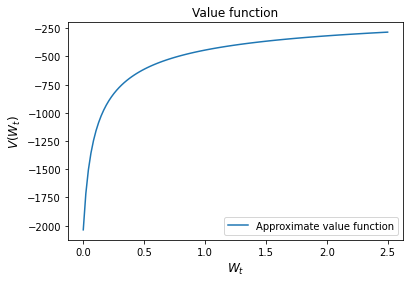

In [ ]:
fig, ax = plt.subplots()

ax.plot(cp.grid, v_star, label='Approximate value function')#由于是迭代得到的结果，因此结果不能认为使精确的
ax.set_ylabel('$V(W_{t})$', fontsize=12)
ax.set_xlabel('$W_{t}$', fontsize=12)
ax.set_title('Value function')
ax.legend()
plt.show()

[0.02133892 0.00186879 0.04308721 0.02684754] [[ 6.08261673e+01  1.63303283e+00 -4.85668474e+01 -3.32762450e-07]
 [ 1.63303283e+00  4.38429106e-02 -1.30390027e+00 -8.93386963e-09]
 [-4.85668474e+01 -1.30390027e+00  3.87783542e+01  2.65694396e-07]
 [-3.32762450e-07 -8.93386962e-09  2.65694395e-07  1.56756046e-14]]


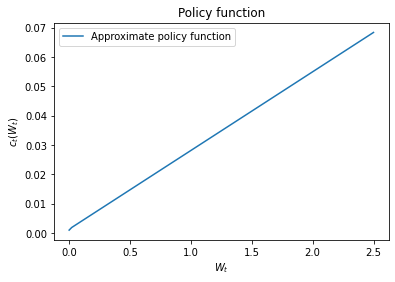

In [ ]:
#由值函数迭代的最优解，代入贝尔曼方程求其策略
fig, ax = plt.subplots()
c_star = cp.bellman_operator(v_star)[1]
def piecewise_linear(x, k):
    # x<x0 ⇒ lambda x: k1*x + y0 - k1*x0
    # x>=x0 ⇒ lambda x: k2*x + y0 - k2*x0
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0-k1*x0, 
                                   lambda x:k2*x + y0-k2*x0])

# 用已有的 (x, y) 去拟合 piecewise_linear 分段函数
p , e = curve_fit(piecewise_linear,cp.grid,c_star )
print(p,e)
ax.plot(cp.grid, c_star, label='Approximate policy function')
ax.set_ylabel(r'$c_{t}(W_{t})$')
ax.set_xlabel('$W_{t}$')
ax.legend()
ax.set_title('Policy function')
plt.show()

**参考文献：**
1. Dynamic economics: quantitative methods and applications  J Adda, R Cooper, RW Cooper - 2003
2. https://python-programming.quantecon.org/